## Выполнил: Сафронский Вячеслав
В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('C:/Users/user/study/stat_9/hw_bootstrap.csv', sep = ';', decimal=",")

In [3]:
df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [4]:
df_Control = df.loc[df.experimentVariant == 'Control']

In [5]:
df_Treatment = df.loc[df.experimentVariant == 'Treatment']

In [6]:
df_Treatment.describe()

,Unnamed: 0,value
count,500.000000,500.000000
mean,750.500000,27.321499
std,144.481833,186.557011
min,501.000000,6.436541
25%,625.750000,9.421968
50%,750.500000,10.025847
75%,875.250000,10.675721
max,1000.000000,3000.000000


In [7]:
df_Control.describe()

,Unnamed: 0,value
count,500.000000,500.000000
mean,250.500000,10.026867
std,144.481833,0.979377
min,1.000000,6.436541
25%,125.750000,9.411024
50%,250.500000,10.018465
75%,375.250000,10.664879
max,500.000000,13.130346


<AxesSubplot:>

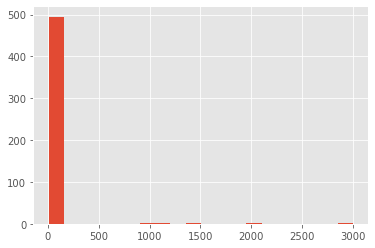

In [8]:
df_Treatment.value.hist(bins=20)

<AxesSubplot:>

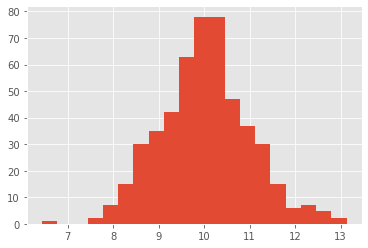

In [9]:
df_Control.value.hist(bins=20)

In [10]:
ss.ttest_ind(df_Treatment.value, df_Control.value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

<b><u> t-test говоит о том, что мы не можем с уверенностью говорить о том, что данные не различаются, так как p-value < 0,05. 

In [11]:
df_Treatment.value.var()

34803.518450208336

In [12]:
df_Control.value.var()

0.9591800678643456

<b><u> дисперсии сильно различаются, что говорит о том, что для представленных данных выполнение t-test некорректно.

In [13]:
ss.mannwhitneyu(df_Treatment.value, df_Control.value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

<b> U-test говорит о том, что мы не можем отбросить нулевую гипотезу о том, что данные не различаются, так как p-value > 0,05. 
Так как мы построили гистограмму распределения, и заметили, что данные в тестовой группе имеют значительные выбросы, вследствие чего дисперсии значительно отличаются, можно утверждать, что для анализа представленных данных лучше подходит 
непараметрический критерий Mann–Whitney.

<b><u> В данном случае, несмотря на имеющиеся выбросы, U-test говорит что значимых различий между данными нет.

<b><u> Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [14]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

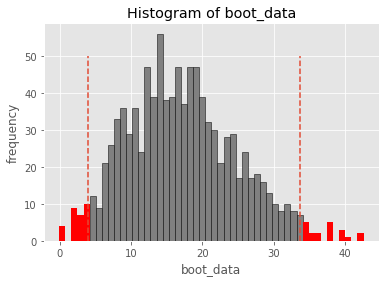

In [15]:
booted_data = get_bootstrap(df_Treatment.value, df_Control.value) # в результате хранится разница двух распределений, ДИ и pvalue

In [16]:
booted_data["p_value"] # альфа

0.025992913471398225

In [17]:
booted_data["quants"] # ДИ

,0
0.025,4.011397
0.975,33.605307


<b> бутстрап для анализа различия средних дает значение p-value < 0.05, что говорит нам о статистических различиях между средними.
<b><u> Причиной этому, как и в случае t-test могут являться выбросы.

<b><u> проведем бутстрап анализ для медиан представленных данных.

In [19]:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

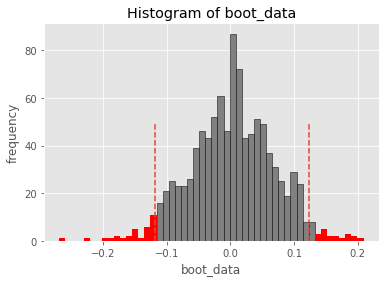

In [20]:
booted_data_median = get_bootstrap_median(df_Treatment.value, df_Control.value)

In [21]:
booted_data_median["p_value"] # альфа

0.9679414980907528

<b> бутстрап для медиан показал занчение p-value > 0.05 (0.97), что говорит о том, что статистически значимой разницы между медианами нет.
<b><u> так как медиана менее чувствительна к выбросам, чем среднее, для вывода будем использовать значение p-value для медианы.

### Вывод: Тестовые данные имеют значительные выбросы значений. Ввиду этого, для представленного набора данных, наиболее целесообразно использовать либо U-test, либо бутстрап анализ медиан. Требования по схожести дисперсий для выполнения t-test не соблюдается, выборка <1000, что не дает нам возможности получить корректные результаты при использовании t-test.
### В результате применения U-test и bootstrap сделан вывод, что эксперимент не удался, и больше зарабатывать с пользователя мы не стали.

<b><i> выполнена дополнительная проверка тестов, при условии исключения выбросов из тестового датафрейма.
<b><i> в данном случае все тесты показывают, что данные статистически не различаются.

<AxesSubplot:>

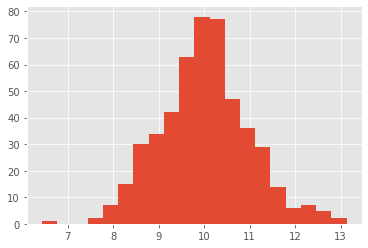

In [22]:
df_Treatment.loc[df_Treatment.value < 20]['value'].hist(bins=20)

In [23]:
df_Treatment_no_outliers = df_Treatment.loc[df_Treatment.value < 20]

In [24]:
ss.ttest_ind(df_Treatment_no_outliers.value, df_Control.value)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

<b><i>t-test говоит о том, что мы не можем с уверенностью говорить о том, что данные не различаются, так как p-value < 0,05. 

In [25]:
df_Treatment_no_outliers.value.var()

0.9567570846493205

In [26]:
df_Control.value.var()

0.9591800678643456

<b><i> дисперсии практически не различаются

In [27]:
ss.mannwhitneyu(df_Treatment_no_outliers.value, df_Control.value)

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

<b><i> U-test говоит о том, что мы не можем отбросить нулевую гипотезу о том, что данные не различаются, так как p-value > 0,05. 

  0%|          | 0/1000 [00:00<?, ?it/s]

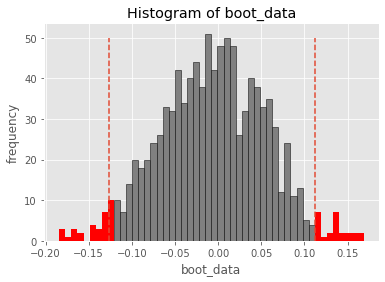

In [28]:
booted_data_no_outliers = get_bootstrap(df_Treatment_no_outliers.value, df_Control.value) 
# в результате хранится разница двух распределений, ДИ и pvalue

In [29]:
booted_data_no_outliers["p_value"] # альфа

0.9146490336353829

In [30]:
booted_data_no_outliers["quants"] # ДИ

,0
0.025,-0.126023
0.975,0.111989


<b><i> бутстрап анализ также не выявляет статистических различий.